# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

# A Gaussian Process Experiment

This investigative experiment using Gaussian Processes (GPs) is devolved towards demonstrating the limitations of GPs in our practical task. Some of the limitations of GPs we investigate in this Notebook are:
1. Overfitting
2. Steep increase of computational cost with the increase of the data set
3. Inability to model heteroscedastic aleatoric uncertainty sources, only epistemic sources.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import warnings
import joblib

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from scipy.stats import norm
import GPy

from tensorflow.keras.layers import Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanSquaredError
from matplotlib.ticker import FuncFormatter

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


##### Auxiliary Functions

In [2]:
FILE_PATH = "figures/gps/"

def evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs=None, y_test_stddevs=None, ci=None):
    
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)    # in %
    test_mae = mean_absolute_error(y_test, y_test_pred)       # in %
    
    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    
    if y_train_stddevs and y_test_stddevs and y_train_stddevs.any() and y_test_stddevs.any() and ci:
        z_value = stats.norm.ppf((1 + ci) / 2)
        train_lower_bound = y_train_pred - z_value * y_train_stddevs
        train_upper_bound = y_train_pred + z_value * y_train_stddevs

        test_lower_bound = y_test_pred - z_value * y_test_stddevs
        test_upper_bound = y_test_pred + z_value * y_test_stddevs

        train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
        test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

        train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
        test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100
        
        print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
        print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")
    
def plot_means_variances(y_true, y_means, y_stddevs, file_suffix=None):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha=.7, color="0.3", linewidth=0, s=2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Predicted vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')

    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)

    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha=.7, color="0.3", linewidth=0, s=2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()

    plt.tight_layout()
    
    if file_suffix is not None:
        plt.savefig(FILE_PATH + f"pred_charts_{file_suffix}.png", bbox_inches='tight')
    plt.show()
    
def plot_confidence_interval_scatter(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.arange(1, bins+1)*100/bins, percentages_within_interval, color='blue', label='Percentage of Residuals within Interval')
    
    # Plot the expected diagonal line (red line)
    plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Expected')

    # Add percentage symbols to x-axis ticks
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))

    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Scatter Plot of Percentage of Residuals within the Confidence Intervals')
    plt.legend()

    plt.show()

## Data Set

In [3]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [4]:
# Datetime column
DATETIME_COL = 'Date.time'

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

# Only consider the turbine with ID 5
TURBINE_ID = 5
df = df_full[df_full['turbine'] == TURBINE_ID]
print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
df = df.reset_index(drop=False) 

Total data points for turbine 5 before removing NaNs:  191579
Total data points for turbine 5 after removing NaNs:  189381


In [5]:
df.head()

,index,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
0,778652,2017-09-25 00:00:00,170.785782,18.711275,117.633080,201.376236,178.246281,4.758976,0.470051,3.839334,...,NaN,NaN,NaN,76.154892,329.839172,47.446136,34.605957,12.856477,5,2017
1,778653,2017-09-25 00:10:00,196.361282,29.352943,132.657440,244.603409,214.993427,5.053728,0.455439,4.297034,...,NaN,NaN,NaN,78.530861,337.024353,45.788548,24.391794,12.387291,5,2017
2,778654,2017-09-25 00:20:00,213.066101,18.548962,175.467987,244.880829,186.659122,4.834767,0.438846,3.727230,...,NaN,NaN,NaN,78.428474,335.595490,44.958530,19.414160,14.047290,5,2017
3,778655,2017-09-25 00:30:00,180.647583,16.838543,143.989594,220.636795,194.940699,4.909376,0.403833,3.910666,...,NaN,NaN,NaN,72.759590,318.466614,45.136253,21.682341,11.815598,5,2017
4,778656,2017-09-25 00:40:00,201.553589,11.615179,178.872192,223.635696,182.866606,4.800600,0.485835,4.098299,...,NaN,NaN,NaN,73.908447,320.857849,44.799519,21.100346,11.945602,5,2017


In [16]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Rotor.bearing.temp.me,Stator1.temp.me,Nacelle.ambient.temp.me,Nacelle.temp.me,Transformer.temp.me,Gear.oil.temp.me,Gear.oil.inlet.temp.me,Top.box.temp.me,Hub.temp.me,Conv.Amb.temp.me,Transformer.cell.temp.me,Motor.axis1.temp.me,Motor.axis2.temp.me,CPU.temp.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me
count,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000
mean,6.061792,0.929598,4.285672,7.826800,65.249559,0.611390,64.235198,66.234087,63.228148,0.665511,62.131779,64.294001,25.147016,62.680004,10.395775,19.545742,48.827492,52.035799,48.283892,24.561808,20.016075,14.146877,16.435012,42.007367,42.461620,53.257354,4.664098,4.664053,4.664393,118.197068,459.291346,21.301466,57.177760,27.941015,624.587598
std,2.767883,0.461186,2.206099,3.482993,10.096854,0.504141,9.916454,10.287366,8.592414,0.576825,8.409253,8.819052,3.963058,7.853748,5.895684,5.386682,19.850288,5.862262,8.085823,3.431033,4.873869,6.028698,5.922955,18.629214,18.868266,3.212041,12.673886,12.673785,12.674054,54.677459,164.758023,36.644667,30.554552,15.813479,631.196896
min,0.129863,0.000000,-0.444250,0.243750,14.565001,0.000000,14.400000,14.600000,13.147500,0.000000,13.100000,13.200000,9.002500,13.720000,-6.800000,1.245000,18.690001,13.857500,9.235000,9.520000,7.762000,-2.642500,-1.037500,10.400000,11.000000,38.000000,0.000000,0.000000,0.000000,-4.160219,5.963073,3.013230,1.225289,2.458500,-21.170280
25%,4.052706,0.595049,2.674919,5.362026,61.002500,0.236114,60.099998,61.900002,61.092499,0.240885,60.400002,61.849998,22.215000,59.665001,6.020000,15.917500,35.562500,49.326313,42.110000,22.900000,16.043158,9.677500,11.925000,27.074500,28.000000,52.000000,0.000000,0.000000,0.000000,83.152820,352.544764,4.978957,36.144118,17.303601,122.224066
50%,5.707567,0.851638,4.071932,7.317771,69.794736,0.475730,68.449997,70.900002,66.140001,0.477723,65.050003,67.000000,25.049999,62.027500,9.690000,19.530000,42.087499,53.122500,50.200000,24.920000,19.000000,13.590000,16.092500,36.849998,37.124000,53.525002,0.026500,0.026500,0.026500,98.062714,404.299846,7.397583,54.777193,25.706060,382.674857
75%,7.657582,1.180467,5.618109,9.794380,72.277500,0.845470,71.199997,73.300003,68.575001,0.928453,67.199997,70.000000,28.059524,64.492499,14.352500,23.075000,54.002631,56.322498,55.132500,26.395000,23.196500,18.242500,20.514999,54.286500,54.245499,55.000000,1.116000,1.116000,1.117000,151.218739,564.198951,14.488859,77.716939,35.893112,967.920566
max,22.151195,5.016237,17.995665,32.264656,81.182500,7.816919,80.800003,81.449997,75.092500,7.473754,74.649994,76.400002,39.097499,103.014999,35.225000,39.430000,107.987503,59.926316,60.208335,39.863889,38.359000,43.762500,42.076316,85.001000,87.000000,68.900000,89.989998,89.989998,90.000000,305.390411,1169.453369,327.393707,272.232208,192.845093,2084.067871


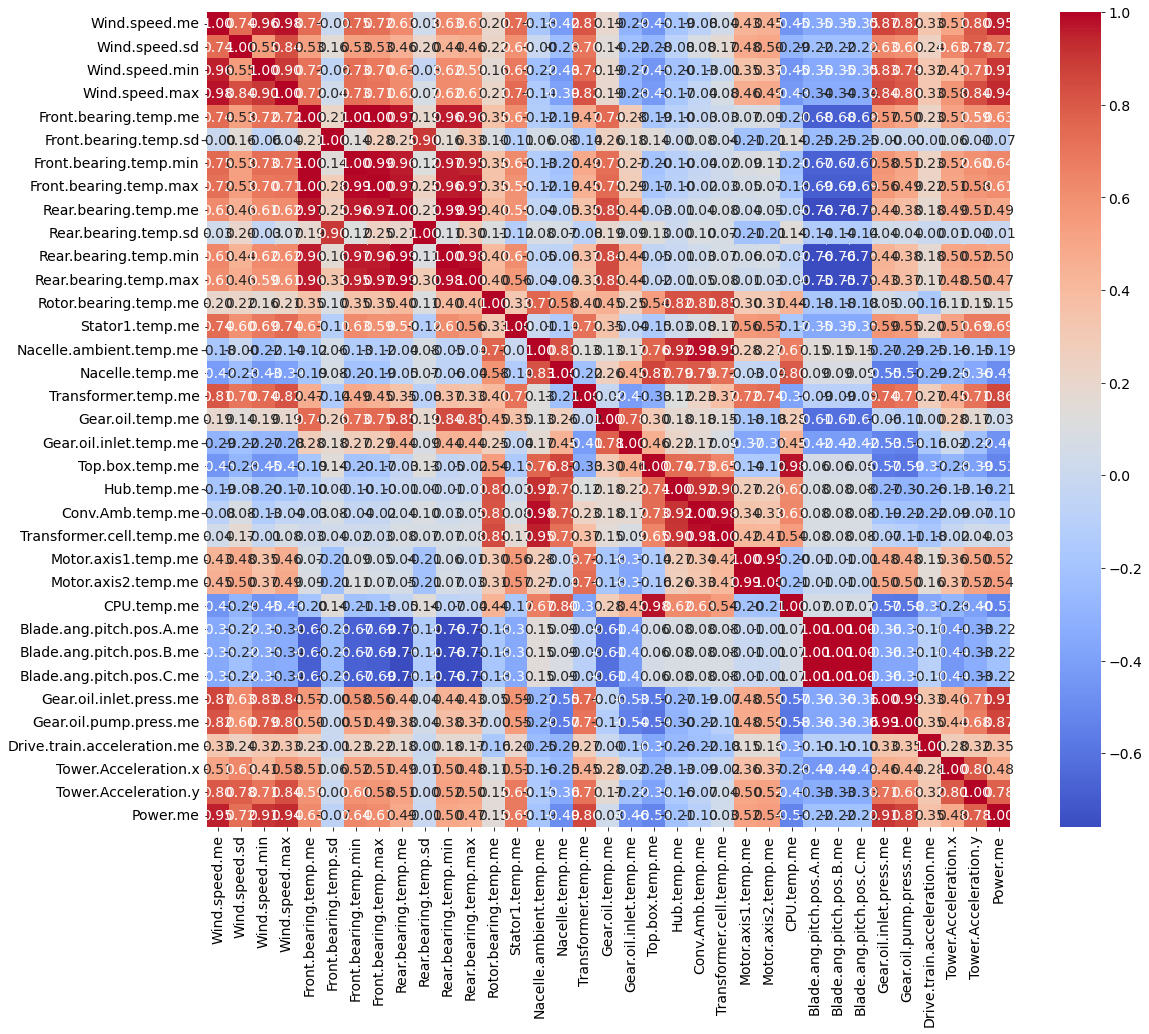

In [17]:
plt.figure(figsize=(18, 15))
correlation_matrix = df[features + [output_feature]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

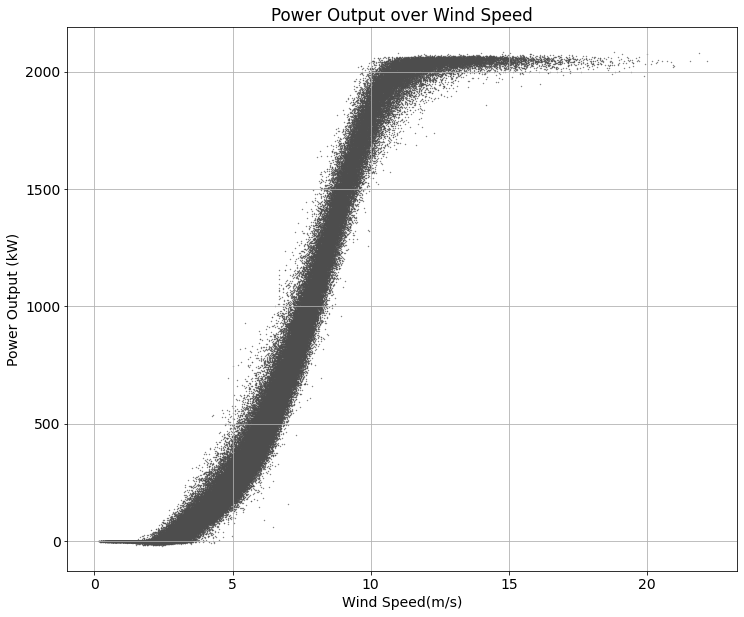

In [18]:
# Plot Power over Wind Speed
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output over Wind Speed')
plt.xlabel('Wind Speed(m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

## Baseline Models

Below are presented two baseline, low computational cost, baseline models. We present a linear regression and a decision tree regression with 5-fold cross-validation. While these model are incapable of quiantifying the uncertainty in their predictions, a property that we require for our probabilistic approach in condition monitoring for a wind turbine's power curve, they provide a prediction error baseline which we can use to evaluate our different Gaussian Processes models. 

In [19]:
# For the baseline models we use the full data set
X = df[features]
y = df[output_feature]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardize the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

### Linear Regression

#### Ordinary Least Square (OLS)

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [24]:
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

Train RMSE: 98.527
Test RMSE: 99.201
Train MAE: 68.000
Test MAE: 68.498


#### Ridge Regression

In [25]:
lr_ridge = Ridge()
lr_ridge.fit(X_train_scaled, y_train)

Ridge()

In [26]:
y_train_pred = lr_ridge.predict(X_train_scaled)
y_test_pred = lr_ridge.predict(X_test_scaled)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

Train RMSE: 98.530
Test RMSE: 99.201
Train MAE: 68.005
Test MAE: 68.501


### Decision Tree with 5-fold CV

In [27]:
# Hyperparameters to search over
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
}

decision_tree_model = DecisionTreeRegressor(random_state=42, min_samples_split=10)

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
decision_tree_model = grid_search.best_estimator_
joblib.dump(decision_tree_model, "./saved_models/decision_tree.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   7.5s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   6.7s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   8.4s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   6.8s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   8.5s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   7.1s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   6.9s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   6.5s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   6.6s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   6.8s
[CV] END ................max_depth=None, min_samples_leaf=10; total time=   5.9s
[CV] END ................max_depth=None, min_sam

['./saved_models/decision_tree.joblib']

In [28]:
best_params = grid_search.best_params_
print("Optimal hyperparameters: ", best_params)

Optimal hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 10}


In [29]:
y_train_pred = decision_tree_model.predict(X_train_scaled)
y_test_pred = decision_tree_model.predict(X_test_scaled)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

Train RMSE: 29.954
Test RMSE: 44.661
Train MAE: 18.211
Test MAE: 26.856


### Random Forest with 5-fold CV

In [30]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_estimators=20), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Optimal hyperparameters: ", best_params)
random_forest_model = grid_search.best_estimator_
joblib.dump(random_forest_model, "./saved_models/random_forest.pkl")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................max_depth=None, min_samples_leaf=1; total time= 4.5min
[CV] END .................max_depth=None, min_samples_leaf=1; total time= 4.1min


KeyboardInterrupt: 

In [ ]:
random_forest_model = joblib.load("./saved_models/random_forest.pkl")

In [ ]:
y_train_pred = random_forest_model.predict(X_train_scaled)
y_test_pred = random_forest_model.predict(X_test_scaled)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

## Gaussian Processes

### Gaussian Processes (Univariate Simplified Illustration)

We illustrate below GP predicting the power output using a single covariate, namely wind speed. The training size is volontarily reduces, 20 samples, to illustrate the GP ability to model heteroscedastic sourcds of epistemic uncertainty. In particular, we show how as the data coverage decreases, the GP is able to adjust the uncertainty of its estimates adequately.

In [31]:
# For illustratice purposes we only consider a small sample of 20,000 datapoints from the 
# full dataset and train a model which accounts only for one input feature, wind speed.
df_sampled = df.sample(n=20_000, random_state=42)

# We only select one feature, wind speed, to illustrate the experiment on charts
X = df_sampled['Wind.speed.me'].values.reshape(-1, 1)
y = df_sampled[output_feature]

# Split the data into training and test sets. To envision the concept of epistemic uncertainty,
# we take a very small train set (20 data points).
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# We select an RBF kernel with additional homoscedastic Gaussian noise on the training observations given by a White kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_demo = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42)
gp_demo.fit(X_train_scaled, y_train)
print("After training the kernel hyperparameters are: ", gp_demo.kernel_)

After training the kernel hyperparameters are:  2.42**2 * RBF(length_scale=2.77) + WhiteKernel(noise_level=0.0299)


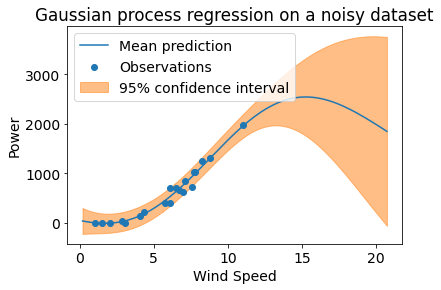

In [32]:
mean_prediction, std_prediction = gp_demo.predict(X_scaled, return_std=True)

plt.scatter(
    X_train,
    y_train,
    label="Observations",
    zorder=3
)

X_sorted, mean_prediction_sorted, std_prediction_sorted = zip(*sorted(zip(X, mean_prediction, std_prediction)))
X_sorted = np.array(X_sorted)
mean_prediction_sorted = np.array(mean_prediction_sorted)
std_prediction_sorted = np.array(std_prediction_sorted)

plt.plot(X_sorted,
         mean_prediction_sorted,
         label="Mean prediction",
         zorder=3
        )

plt.fill_between(
    X_sorted.ravel(),
    mean_prediction_sorted - 1.96 * std_prediction_sorted,
    mean_prediction_sorted + 1.96 * std_prediction_sorted,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
    zorder=1
)

plt.title("Gaussian process regression on a noisy dataset")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend()
plt.show()

In [33]:
y_train_pred = gp_demo.predict(X_train_scaled, return_std=False)
y_test_pred = gp_demo.predict(X_test_scaled, return_std=False)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

Train RMSE: 81.703
Test RMSE: 107.260
Train MAE: 57.173
Test MAE: 71.154


This really shows the data efficiency properties of GPs. With only 20 data points and only one input feature, the GP above can compete with other baseline models (e.g., linear regression).

GPs only model heteroscedasticity in epistemic uncertainty, the inherit uncertainty of the model. The noise is assumed to have constant variance throughtout the domain space, hence the white noise added to the kernel function. Howevever, we can see how the prediction confidence decreases as the data points become more sparse towards the lower and upper bounds of the wind speed's domain. This is because with a lack of training samples in those feature space regions, the model is uncertain what should be the prediction, hence model estimates with much lower confidence. The advantage of GPs for our task ast hand of normal behaviour modelling is that they can express confidence intervals out of the box, being a statistical model based on an infinitely dimensional Gaussian. 

However, the high-frequency of data sampling and large amounts of data allow epistemic uncertainty can be reduced with training to a level that it becomes irrelevant when compared to the aleatoric uncertainty, or noise. This, plus the computational constraints of GPs which hinder the ability to reduce its epistemic uncertainty, motivate the research of probabilistic neural networks presented in the rest of the Jupyter Notebooks. Nevertheless, we present in this Notebook an experiment using GPs as a baseline study.

## GPs

In [34]:
# Take a random sample of 1000 datapoints. This because Gaussian Processes' training
# require the inversion of the Kernel matrix, which is of size nxn for n data points.
# This has complexity O(n^3), which is only feasible with a few thousands data points.
# Because of the computational cost of GPs, we only consider 1,000 training data points.
# Testing is computational inexpensive, so we use a larger dataset.
num_train_points = 1_000
df_sampled = df.sample(n=int(df.shape[0]*0.2) + num_train_points, random_state=42)

X = df_sampled[features]
y = df_sampled[output_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train_points, random_state=42)

# Standardize the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### GP using only wind speed (RBF + WhiteNoise Kernel)

In [35]:
# We select an RBF kernel with additional Gaussian measurement noise on the training observations given by a White kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_only_wind = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42, alpha=1e-4)
gp_only_wind.fit(X_train_scaled[:, :1], y_train)

print("After training the kernel hyperparameters are: ", gp_only_wind.kernel_)

After training the kernel hyperparameters are:  1.3**2 * RBF(length_scale=1.22) + WhiteKernel(noise_level=0.0129)


In [36]:
y_train_pred, y_train_stddevs = gp_only_wind.predict(X_train_scaled[:, :1], return_std=True)
y_test_pred, y_test_stddevs = gp_only_wind.predict(X_test_scaled[:, :1], return_std=True)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

Train RMSE: 69.178
Test RMSE: 67.410
Train MAE: 46.631
Test MAE: 46.802


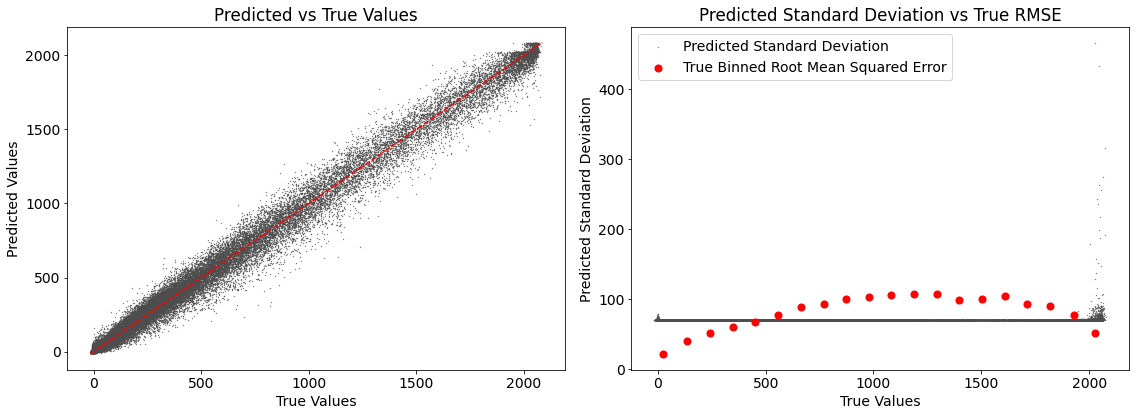

In [37]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, "only_wind")

In [38]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, "only_wind", bins=20)

NameError: name 'plot_confidence_interval_histogram' is not defined

### GP using all input features (RBF + WhiteNoise Kernel)

In [ ]:
# We select an RBF kernel with additional Gaussian measurement noise on the training observations given by a White kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42, alpha=1e-4)
gp.fit(X_train_scaled, y_train)

print("After training the kernel hyperparameters are: ", gp.kernel_)

In [ ]:
y_train_pred, y_train_stddevs = gp.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_stddevs = gp.predict(X_test_scaled, return_std=True)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

### GPs using all input features (comparison of different Kernels)

In [ ]:
kernels = [
    RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    RationalQuadratic(length_scale=1.0, alpha=1.0),
    DotProduct(sigma_0=1.0),
    ExpSineSquared(length_scale=1.0, periodicity=1.0),
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create and fit the GP model with each kernel
    for kernel in kernels:
        gp = GaussianProcessRegressor(kernel=kernel + WhiteKernel(), n_restarts_optimizer=9, normalize_y=True, random_state=42)
        gp.fit(X_train_scaled, y_train)

        print("Kernel: ", str(gp.kernel_))
        y_train_pred, y_train_stddevs = gp.predict(X_train_scaled, return_std=True)
        y_test_pred, y_test_stddevs = gp.predict(X_test_scaled, return_std=True)

        evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)
        file_suffix = str(gp.kernel_).split('(')[0]
        plot_means_variances(y_test, y_test_pred, y_test_stddevs, file_suffix)
        plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, file_suffix, bins=20)
        print("\n")

The train error is, for every GP model evaluated, much lower than the test error. This suggest that the GP, which is a low bias model, is significantly overfitting the training data. This is because GPs tend to have high predictive variance, meaning they produce significantly different models for different samples of datasets. We propose a dimensionality reduction and feature extraction technique through the use of an autoencoder to try to reduce overfitting.

### Autoencoder Feature Extractor + GP

We input the data into an Autoencoder to reduce dimensionality and extract feature. The purpose of the Autoencode is to reconstruct the original input while being forced into an encoding of 10 features and minimizing entropy. We extract a latent feature space to be used as the input to the subsequent GPs.

In [ ]:
# Dataset to train the autoencoder (full dataset)
X = df[features]
y = df[output_feature]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled_full = scaler.fit_transform(X_train_full)
X_test_scaled_full = scaler.transform(X_test_full)

In [ ]:
def autoencoder(encoding_dim):
    # Define the autoencoder model
    inputs = Input(shape=(len(features),))
    hidden = Dense(int(len(features)*0.7), activation='relu')(inputs)
    encoded = Dense(encoding_dim, activation='relu')(hidden)
    hidden = Dense(int(len(features)*0.7), activation='relu')(encoded)
    decoded = Dense(len(features), activation='linear')(encoded)
    
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    return autoencoder, encoder

encoding_dim = 15  # Define the dimensionality of the encoded representation
autoencoder, encoder = autoencoder(encoding_dim)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_scaled_full, X_train_scaled_full,
                epochs=50, batch_size=32,
                validation_split=0.1,
                callbacks=early_stopping
               )

In [ ]:
# Calculate the reconstruction error
X_train_decoded_full = autoencoder.predict(X_train_scaled_full)
X_test_decoded_full = autoencoder.predict(X_test_scaled_full)

mse_train = np.mean(np.square(X_train_scaled_full - X_train_decoded_full))
mse_test = np.mean(np.square(X_test_scaled_full - X_test_decoded_full))
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print("Train Reconstruction RMSE:", rmse_train)
print("Test Reconstruction RMSE:", rmse_test)

In [ ]:
norms = np.linalg.norm(X_test_scaled, axis=1)
mean_norm = np.mean(norms)
print("Normalized Reconstruction Test RMSE: ", rmse_test/mean_norm)

In [ ]:
# We encode the input data of train and test sets into the latent feature space
X_train_encoded_sample = encoder.predict(X_train_scaled)
X_test_encoded_sample = encoder.predict(X_test_scaled)

# Trained GP with RBF Kernel trained using the encoded data via the encoder obtained from the autoencoder
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_autoencoder = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42)
gp_autoencoder.fit(X_train_encoded_sample, y_train)

In [ ]:
print("Kernel: ", str(gp_autoencoder.kernel_))
y_train_pred, y_train_stddevs = gp_autoencoder.predict(X_train_encoded_sample, return_std=True)
y_test_pred, y_test_stddevs = gp_autoencoder.predict(X_test_encoded_sample, return_std=True)

evaluate_metrics(np.array(y_train), np.array(y_test), y_train_pred, y_test_pred)

In [ ]:
file_suffix = "autoencoder"
plot_means_variances(y_test, y_test_pred, y_test_stddevs, file_suffix)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, file_suffix, bins=20)

### GP with ARD Kernel

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Create the GaussianProcessRegressor with the ARD kernel
    np.random.seed(42)
    kernel = RBF(np.ones(X_train_scaled.shape[1]), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
    gp_ard = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42, alpha=1e-4)

    gp_ard.fit(X_train_scaled, y_train)
    print("After training the kernel hyperparameters are: ", gp_ard.kernel_)

In [ ]:
y_train_pred, y_train_std = gp_ard.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gp_ard.predict(X_test_scaled, return_std=True)

evaluate_metrics(y_train, y_test, y_train_pred, y_test_pred)

In [ ]:
file_suffix = "ard"
plot_means_variances(y_test, y_test_pred, y_test_stddevs, file_suffix)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, file_suffix, bins=20)

### Sparse GP

We consider the entire data set, as we will be using inducing points approximation. Using the entire data set is necessary to compare this approach with other deep learning methodology where the entire data set is used. In this case 500 inducing points were used.

In [6]:
X_full = df[features]
y_full = df[output_feature]

# Split the data into training and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Standardize the data 
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

In [49]:
np.random.seed(42)
kernel = GPy.kern.RBF(input_dim=X_train_full.shape[1])
num_inducing = 100

# Considering 500 inducing points
gp_inducing = GPy.models.SparseGPRegression(X_train_full_scaled, np.array(y_train_full).reshape(-1, 1), kernel=kernel, num_inducing=num_inducing)
gp_inducing.optimize(messages=True)

In [54]:
np.save('gp_params3.npy', gp_inducing.param_array)
np.save('gp_y3.npy', y_full)
np.save('gp_X3.npy', X_full)

# Load model
y_load = np.load('gp_y3.npy')
X_load = np.load('gp_X3.npy')
print(y_load.shape)
y_load = np.expand_dims(y_load, axis=1)
gp_load = GPy.models.SparseGPRegression(X_load, y_load, 
                                   initialize=False,
                                   num_inducing=num_inducing,
                                   kernel=GPy.kern.RBF(input_dim=X_train_full.shape[1])) # Kernel is problematic here

gp_load.update_model(False)
gp_load.initialize_parameter()
print(type(gp_load))
gp_load[:] = np.load('gp_params3.npy')
print(type(gp_load))

gp_load.update_model(True)


(189381,)
<class 'GPy.models.sparse_gp_regression.SparseGPRegression'>


AttributeError: 'SparseGPRegression' object has no attribute 'kernel'

In [51]:
gp_inducing = gp_load

In [52]:
y_train_pred, y_train_vars = gp_inducing.predict(X_train_full_scaled)
y_test_pred, y_test_vars = gp_inducing.predict(X_test_full_scaled)
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()

if not isinstance(y_train_full, np.ndarray):
    y_train_full = y_train_full.to_numpy()
if not isinstance(y_test_full, np.ndarray):
    y_test_full = y_test_full.to_numpy()
    
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()
y_train_stddevs = np.sqrt(y_train_vars.squeeze())
y_test_stddevs = np.sqrt(y_test_vars.squeeze())


evaluate_metrics(y_train_full, y_test_full, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, 0.99)

Train RMSE: 888.267
Test RMSE: 886.857
Train MAE: 625.403
Test MAE: 623.395


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plot_means_variances(y_test_full, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test_full, bins=20)

In [57]:
!conda install gpytorch

^C


In [72]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:5, :].clone(), likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [73]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(torch.tensor(X_train_full_scaled), torch.tensor(y_train_full), likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [80]:
import tqdm

training_iterations = 10

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.tqdm(range(training_iterations), desc="Train")

    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(torch.tensor(X_train_full_scaled))
        # Calc loss and backprop derivatives
        loss = -mll(output, torch.tensor(y_train_full))
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        torch.cuda.empty_cache()

%time train()

Train:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Calling torch.linalg.cholesky on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

In [77]:
!conda list mkl

# packages in environment at C:\Users\filip\anaconda3:
#
# Name                    Version                   Build  Channel
mkl                       2021.4.0           h0e2418a_729    conda-forge
mkl-include               2024.0.0         h66d3029_49658    conda-forge
mkl-service               2.4.0            py38h2bbff1b_0  
mkl_fft                   1.3.1            py38h277e83a_0  
mkl_random                1.2.2            py38hf11a4ad_0  


SyntaxError: invalid syntax (<ipython-input-79-e6c45b8f8ee0>, line 1)